## call "~/.local/bin/poetry" if poetry keyword not working on mac

In [1]:

# TODO split based on farms


# (iin both ground truth & supervised) remove images before May 1st, remove everything after Sept 30
# drop duplicates based on BANDS

# for image-pair level:(what we have rn)
# keep the images after harvest event removed

# for farm level:
# do not remove images after har_evnt==True in ground truth set


# TODO show pinned points for grounTruth set & later the other set

In [2]:
import datetime
import geopandas
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
#local scripts

from scripts import veg_indices, utilities, plots
#from scripts.utilities import *

In [4]:
# cpied from learning_about-data.ipynb
BANDS_DICT = {   'B2': 'Blue',
            'B3': 'Green',
            'B4': 'Red',
            'B5': 'Red_Edge_1',
            'B6': 'Red_Edge_2',
            'B7': 'Red_Edge_3',
            'B8': 'NIR',
            'B8A': 'Red_Edge_4',
            'B11': 'SWIR_1',
            'B12': 'SWIR_2'}

BANDS = list(BANDS_DICT.keys())

In [5]:
NUMERIC_COLS = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12','RVI',
                'ARVI','PSSRa','NDI45','GNDVI','MCARI','IRECI','CIr','MTCI',
                'NDVIre','NIRv','EVI','NDTI','NDMI','MSI','GCI','NBRI','BSI',
                'NDWI','NDSI','NDVI','RVI_diff','ARVI_diff','PSSRa_diff',
                'NDI45_diff','GNDVI_diff','MCARI_diff','IRECI_diff','CIr_diff',
                'MTCI_diff','NDVIre_diff','NIRv_diff','EVI_diff','NDTI_diff',
                'NDMI_diff','MSI_diff','GCI_diff','NBRI_diff','BSI_diff','NDWI_diff',
                'NDSI_diff','NDVI_diff','RVI_prev','ARVI_prev','PSSRa_prev','NDI45_prev',
                'GNDVI_prev','MCARI_prev','IRECI_prev','CIr_prev','MTCI_prev','NDVIre_prev',
                'NIRv_prev','EVI_prev','NDTI_prev','NDMI_prev','MSI_prev','GCI_prev',
                'NBRI_prev','BSI_prev','NDWI_prev','NDSI_prev','NDVI_prev']

NUM_SAMPLES = 16

In [6]:
file_name = "merged_images_supSpecLarge"
df = geopandas.read_file(f'../data/{file_name}')

file_name = "merged_images_groundTruth"
test_df = geopandas.read_file(f'../data/{file_name}')
#validate_df = test_df

In [7]:

def get_ordered_rdm_forests_features():
    # first one is the most important
    return ['B4', 'B2', 'RVI', 'CIr', 'B3', 'NDVI', 'NDVIre', 'B5', 'NDI45',
       'MTCI_prev', 'IRECI', 'PSSRa', 'MTCI_diff', 'NDSI', 'NDWI', 'GNDVI',
       'ARVI', 'NDVIre_diff', 'NDMI_prev', 'NBRI_prev', 'ARVI_diff',
       'NDMI_diff', 'CIr_diff', 'MSI_prev', 'GNDVI_diff', 'NDWI_diff',
       'NIRv_prev', 'NBRI', 'B11', 'NDI45_prev', 'MTCI', 'B12', 'MSI_diff',
       'NDMI', 'NDI45_diff', 'BSI_diff', 'GCI', 'BSI_prev', 'NBRI_diff',
       'NDSI_diff', 'NDSI_prev', 'CIr_prev', 'BSI', 'ARVI_prev', 'NDTI_diff',
       'NDTI_prev', 'NIRv_diff', 'EVI', 'MCARI', 'EVI_prev', 'NDTI',
       'RVI_diff', 'MSI', 'MCARI_diff', 'B6', 'NDVI_prev', 'NDVIre_prev',
       'RVI_prev', 'IRECI_prev', 'PSSRa_prev', 'GCI_diff', 'IRECI_diff',
       'PSSRa_diff', 'NDVI_diff', 'MCARI_prev', 'B8A', 'EVI_diff', 'B7',
       'GCI_prev', 'B8', 'NIRv', 'NDWI_prev', 'GNDVI_prev']
    

SELECTED_FEATURES = ['NDVI', 'RVI', 'BSI', 'MCARI_prev', 'B4']

#SELECTED_FEATURES = NUMERIC_COLS
#SELECTED_FEATURES = train_df[SELECTED_FEATURES].dropna(axis=1).columns

#SELECTED_FEATURES = get_ordered_rdm_forests_features()[:5] # get top N features

print("selected features:", SELECTED_FEATURES)

def get_X_y(dataframe: pd.DataFrame):
    df_X = dataframe[SELECTED_FEATURES]
    #df_X = df_X.dropna(axis=1)
    X = df_X.to_numpy().reshape((df_X.shape[0], df_X.shape[1], 1))
    y = dataframe["har_evnt"].to_numpy().astype(np.float32)
    return X, y

selected features: ['NDVI', 'RVI', 'BSI', 'MCARI_prev', 'B4']


# Separate by Farm

In [8]:
from sklearn.model_selection import train_test_split

def separate_by_farm(df:pd.DataFrame):
    points_df_list = []
    for p in  df['point_idx'].unique(): # ['p0','p1','p2','p3','p4', ...]
        curr_df = df[df["point_idx"] == p]
        points_df_list.append(curr_df)
    len(points_df_list)

    training_df_list, validation_df_list = train_test_split(points_df_list, train_size=0.8, random_state=42)

    print(len(training_df_list))
    print(len(validation_df_list))

    # combine into two dataframes
    train_df = pd.concat(training_df_list)
    validate_df = pd.concat(validation_df_list)
    print(train_df.shape, validate_df.shape)
    
    return train_df, validate_df

validate_df, train_df = separate_by_farm(df)

2084
522
(4694, 85) (1151, 85)


# Random Upsampling

In [9]:
#%%script echo skipping
def apply_random_upsampling(df):
    har_evnt_true_df = df[df["har_evnt"]]
    har_evnt_false_df = df[df["har_evnt"] == False]
    print(har_evnt_true_df.shape)
    print(har_evnt_false_df.shape)

    from sklearn.utils import resample

    upsampled_har_evnt_true_df = resample(har_evnt_true_df, n_samples=har_evnt_false_df.shape[0],
                                                    replace=True, random_state=42)
    print(upsampled_har_evnt_true_df.shape)

    return pd.concat([upsampled_har_evnt_true_df, har_evnt_false_df])
    print(df.shape)

train_df = apply_random_upsampling(train_df)

(404, 85)
(747, 85)
(747, 85)


# Convert to Numpy

In [10]:
X_train, y_train = get_X_y(train_df)
print(X_train.shape, y_train.shape)

X_validate, y_validate = get_X_y(validate_df)
print(X_validate.shape, y_validate.shape)

X_test, y_test = get_X_y(test_df)
print(X_test.shape, y_test.shape)

(1494, 5, 1) (1494,)
(4694, 5, 1) (4694,)
(1682, 5, 1) (1682,)


In [11]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
model = tf.keras.Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    BatchNormalization(),
    Dense(units=32, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=8, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 64)                2

In [13]:
metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall()] # because imbalanced data
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

In [14]:

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

filepath = 'my_best_model.hdf5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_precision', verbose=1, \
                             save_best_only=True, save_weights_only=False, \
                             mode='auto', save_frequency=1)

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_validate, y_validate), callbacks=[earlyStopping, checkpoint])

Epoch 1/200


2023-05-27 17:55:27.962706: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/47 [..............................] - ETA: 14s - loss: 0.6422 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 1: val_precision improved from inf to 0.38589, saving model to my_best_model.hdf5
47/47 [==============================] - 1s 5ms/step - loss: 0.6576 - precision: 0.7492 - recall: 0.3039 - val_loss: 0.6920 - val_precision: 0.3859 - val_recall: 0.9387
Epoch 2/200
 1/47 [..............................] - ETA: 0s - loss: 0.6884 - precision: 0.7692 - recall: 0.5000
Epoch 2: val_precision improved from 0.38589 to 0.36529, saving model to my_best_model.hdf5
47/47 [==============================] - 0s 2ms/step - loss: 0.6164 - precision: 0.7398 - recall: 0.6586 - val_loss: 0.7052 - val_precision: 0.3653 - val_recall: 0.9720
Epoch 3/200
 1/47 [..............................] - ETA: 0s - loss: 0.6033 - precision: 0.7059 - recall: 0.8000
Epoch 3: val_precision did not improve from 0.36529
47/47 [==============================] - 0s 2ms/step - loss: 0.5616 - precision: 0.7260 - reca

In [15]:
model = tf.keras.models.load_model(filepath)

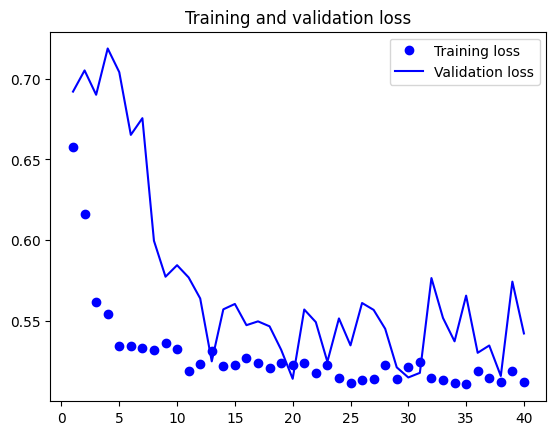

In [16]:
import matplotlib.pyplot as plt

#acc = history.history['binary_accuracy']
#val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

#plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
#plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
import sklearn
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


def plot_confusion_matrix(actual, predicted):
    print(metrics.confusion_matrix(actual, predicted))
    confusion_matrix = metrics.confusion_matrix(actual, predicted, normalize='true')

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    


In [18]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')

def get_prediction_nn(X_in, model):
    y_predict = np.array(list(model.predict(X_in)))
    y_predict = y_predict.reshape(y_predict.shape[0])
    return y_predict

def evaluate(X_in: np.ndarray, y_in:np.array, y_predict:np.array, threshold:int=None) -> int:
    if not threshold:
        thresholds = np.arange(0, 1, 0.001) # define thresholds
        # evaluate each threshold
        scores = [metrics.f1_score(y_in, to_labels(y_predict, t)) for t in thresholds]
        idx = np.argmax(scores)
        threshold = thresholds[idx]
        print("F1 Score:", scores[idx])
    print("Threshold:", threshold)
    func = np.vectorize(lambda x: 0 if x < threshold else 1)
    print(np.unique(func(y_predict), return_counts=True))
    print(sklearn.metrics.classification_report(y_in, func(y_predict)))
    plot_confusion_matrix(y_in, func(y_predict))
    
    return threshold    

X_train
47/47 [==============================] - 0s 430us/step
F1 Score: 0.7145318782309018
Threshold: 0.539
(array([0, 1]), array([500, 994]))
              precision    recall  f1-score   support

         0.0       0.75      0.50      0.60       747
         1.0       0.63      0.83      0.71       747

    accuracy                           0.67      1494
   macro avg       0.69      0.67      0.66      1494
weighted avg       0.69      0.67      0.66      1494

[[375 372]
 [125 622]]


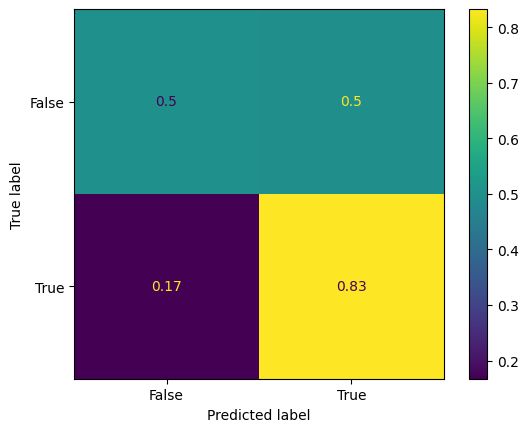

0.539

In [19]:
print("X_train")
evaluate(X_train, y_train, get_prediction_nn(X_train, model))

X_validate
147/147 [==============================] - 0s 358us/step
F1 Score: 0.6222222222222222
Threshold: 0.543
(array([0, 1]), array([2312, 2382]))
              precision    recall  f1-score   support

         0.0       0.86      0.63      0.73      3161
         1.0       0.51      0.79      0.62      1533

    accuracy                           0.68      4694
   macro avg       0.69      0.71      0.68      4694
weighted avg       0.75      0.68      0.69      4694

[[1997 1164]
 [ 315 1218]]


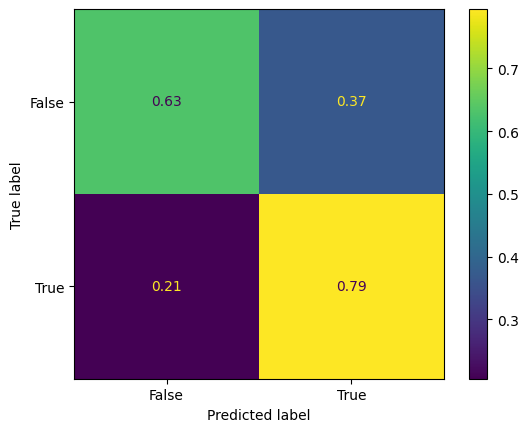

0.543

In [20]:
print("X_validate")
evaluate(X_validate, y_validate, get_prediction_nn(X_validate, model))

X_test
53/53 [==============================] - 0s 377us/step
F1 Score: 0.5587467362924281
Threshold: 0.548
(array([0, 1]), array([1228,  454]))
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87      1370
         1.0       0.47      0.69      0.56       312

    accuracy                           0.80      1682
   macro avg       0.70      0.76      0.71      1682
weighted avg       0.84      0.80      0.81      1682

[[1130  240]
 [  98  214]]


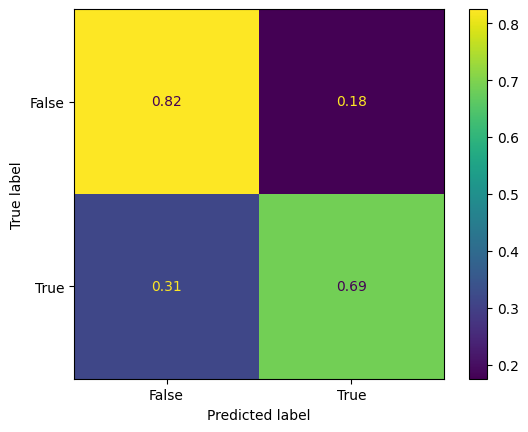

In [21]:
print("X_test")
threshold = evaluate(X_test, y_test, get_prediction_nn(X_test, model))

1/1 [==============================] - 0s 15ms/step
F1 Score: 0.7324840764331212
Threshold: 0.001
(array([0, 1]), array([238, 316]))
              precision    recall  f1-score   support

         0.0       0.66      0.64      0.65       242
         1.0       0.73      0.74      0.73       312

    accuracy                           0.70       554
   macro avg       0.69      0.69      0.69       554
weighted avg       0.70      0.70      0.70       554

[[156  86]
 [ 82 230]]


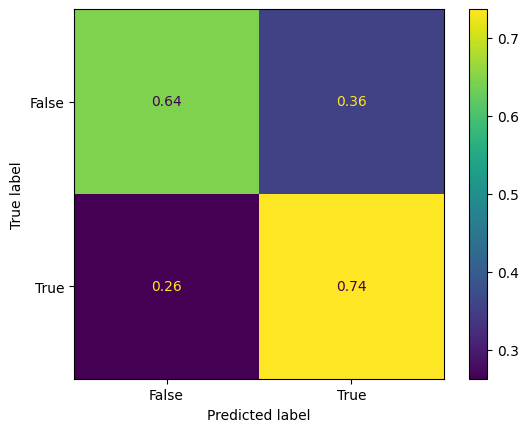

In [22]:
def predict_by_farm():
    farm_level_prediction = []
    farm_level_true_labels = []
    #for i in range(7, 11 + 1):
    for i in np.unique(test_df.point_idx):
        bools = test_df["point_idx"] == i
        curr_X_test = X_test[bools]
        curr_y_test = y_test[bools]
                
        curr_y_predict = get_prediction_nn(curr_X_test, model)
        func = np.vectorize(lambda x: 0 if x < threshold else 1)
        
        true_label = max(curr_y_test)
        predicted_label = max(func(curr_y_predict))
        
        farm_level_true_labels.append(true_label)
        farm_level_prediction.append(predicted_label)
    
    evaluate(None, farm_level_true_labels, farm_level_prediction)
    return farm_level_true_labels, farm_level_prediction

farm_level_true_labels, farm_level_prediction = predict_by_farm()

# Random Forests Feature Selection

In [23]:


def rm_extradim(X, y):
    X, y = X.reshape(X.shape[0], X.shape[1]), y.reshape(y.shape[0])
    return X, y
    

X_train, y_train = rm_extradim(X_train, y_train)
X_validate, y_validate = rm_extradim(X_validate, y_validate)
X_test, y_test = rm_extradim(X_test, y_test)

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

RandomForestClassifier()

X_train
F1 Score: 1.0
Threshold: 0.001
(array([0, 1]), array([747, 747]))
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       747
         1.0       1.00      1.00      1.00       747

    accuracy                           1.00      1494
   macro avg       1.00      1.00      1.00      1494
weighted avg       1.00      1.00      1.00      1494

[[747   0]
 [  0 747]]


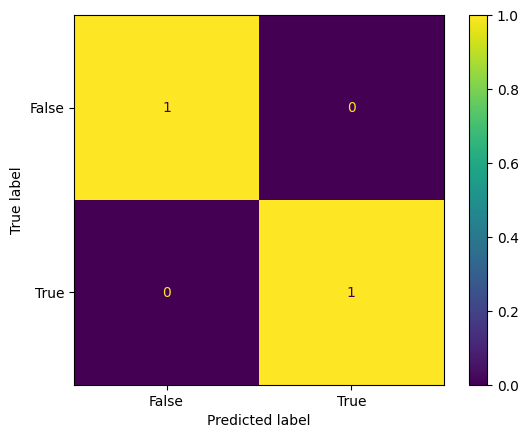

0.001

In [24]:
print("X_train")
y_predict = rf.predict(X_train)
evaluate(X_train, y_train, y_predict)

X_validate
F1 Score: 0.6006968641114983
Threshold: 0.001
(array([0, 1]), array([3357, 1337]))
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82      3161
         1.0       0.64      0.56      0.60      1533

    accuracy                           0.76      4694
   macro avg       0.72      0.71      0.71      4694
weighted avg       0.75      0.76      0.75      4694

[[2686  475]
 [ 671  862]]


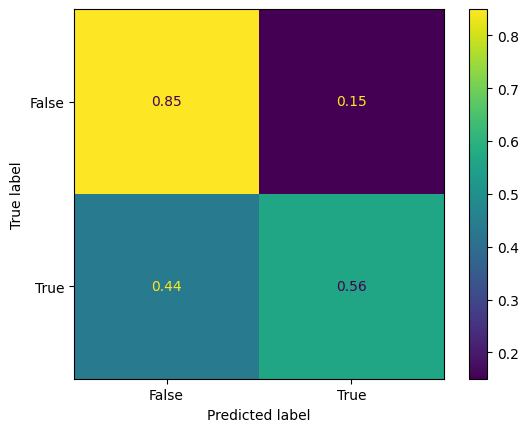

0.001

In [25]:
print("X_validate")
y_predict = rf.predict(X_validate)
evaluate(X_validate, y_validate, y_predict)

X_test
F1 Score: 0.49930651872399434
Threshold: 0.001
(array([0, 1]), array([1273,  409]))
              precision    recall  f1-score   support

         0.0       0.90      0.83      0.86      1370
         1.0       0.44      0.58      0.50       312

    accuracy                           0.79      1682
   macro avg       0.67      0.70      0.68      1682
weighted avg       0.81      0.79      0.80      1682

[[1141  229]
 [ 132  180]]


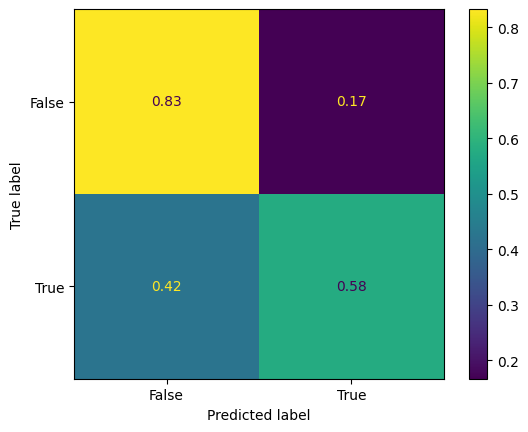

In [26]:
print("X_test")

y_predict = rf.predict(X_test)
threshold = evaluate(X_test, y_test, y_predict)

In [27]:
np.unique(y_train, return_counts=True)

(array([0., 1.], dtype=float32), array([747, 747]))

In [28]:
feature_importances_df = pd.DataFrame(rf.feature_importances_,
                    index=SELECTED_FEATURES, 
                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances_df

,importance
B4,0.277239
BSI,0.213268
MCARI_prev,0.177364
RVI,0.171396
NDVI,0.160733


In [29]:
feature_importances_df.T.columns

Index(['B4', 'BSI', 'MCARI_prev', 'RVI', 'NDVI'], dtype='object')

In [30]:
def farm_level_prediction(test_df: pd.DataFrame): # test df
    d

In [31]:
len(BANDS)

10

In [32]:
test_df[["har_evnt", "finHarvDat", "image_idx", "point_idx"] + BANDS[:1] + ["NDVI", "NDVI_diff", "NDVI_prev"]]

,har_evnt,finHarvDat,image_idx,point_idx,B2,NDVI,NDVI_diff,NDVI_prev
0,False,2022-08-11,i8,p0,0.02430,0.781963,-0.068468,0.850431
1,False,2022-08-11,i9,p0,0.06640,0.198418,-0.583545,0.781963
2,True,2022-08-11,i10,p0,0.10555,0.214999,0.016581,0.198418
3,False,NaT,i7,p1,0.05555,0.571502,0.008652,0.562850
4,False,NaT,i8,p1,0.03895,0.729047,0.157545,0.571502
...,...,...,...,...,...,...,...,...
1677,False,NaT,i7,p557,0.04520,0.577412,0.095066,0.482345
1678,False,NaT,i8,p557,0.05730,0.585551,0.008140,0.577412
1679,False,NaT,i9,p557,0.05375,0.545354,-0.040197,0.585551
1680,False,NaT,i10,p557,0.04920,0.422256,-0.123098,0.545354


In [33]:
df[NUMERIC_COLS]

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,...,EVI_prev,NDTI_prev,NDMI_prev,MSI_prev,GCI_prev,NBRI_prev,BSI_prev,NDWI_prev,NDSI_prev,NDVI_prev
0,0.04935,0.08010,0.10350,0.14255,0.17240,0.19115,0.2088,0.22245,0.23650,0.16900,...,0.404182,0.211338,0.217636,0.642527,2.719391,0.410112,-0.140385,-0.576217,-0.409996,0.622870
1,0.06410,0.08020,0.11040,0.11960,0.14190,0.15560,0.1682,0.17880,0.24800,0.19840,...,0.180348,0.166461,-0.062205,1.132663,1.606742,0.105347,0.136839,-0.445483,-0.493999,0.337176
2,0.12740,0.17840,0.23820,0.25630,0.26410,0.27740,0.3128,0.31360,0.38320,0.27630,...,0.107049,0.111111,-0.191735,1.474435,1.097257,-0.082379,0.213476,-0.354267,-0.511274,0.207466
3,0.06420,0.09100,0.09740,0.14350,0.23670,0.26680,0.2780,0.28760,0.26630,0.16070,...,0.431182,0.227713,0.070774,0.867808,2.741192,0.293753,-0.036388,-0.578165,-0.529039,0.620647
4,0.11160,0.15020,0.19300,0.20990,0.28560,0.31450,0.3532,0.34570,0.32930,0.20170,...,0.326961,0.247307,0.021495,0.957914,2.054945,0.267381,0.030458,-0.506775,-0.490624,0.481087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840,0.06440,0.09275,0.13040,0.16295,0.17865,0.19720,0.2158,0.22230,0.23995,0.18210,...,0.315591,0.164515,0.078075,0.855159,2.661017,0.239514,-0.020762,-0.570909,-0.515826,0.564678
5841,0.08600,0.10680,0.12940,0.15590,0.20690,0.21520,0.2098,0.23930,0.26860,0.18630,...,0.140905,0.137069,-0.052990,1.111909,1.326685,0.084695,0.138575,-0.398801,-0.442441,0.246678
5842,0.07300,0.10240,0.10150,0.15580,0.24680,0.26280,0.2746,0.27670,0.28320,0.19100,...,0.149866,0.180919,-0.122910,1.280267,0.964419,0.059328,0.147305,-0.325332,-0.431007,0.237028
5843,0.03575,0.05850,0.04325,0.08865,0.15335,0.16835,0.1678,0.17395,0.15510,0.09505,...,0.323890,0.194433,-0.015418,1.031318,1.681641,0.179553,0.050662,-0.456764,-0.468880,0.460250


In [34]:
len(NUMERIC_COLS)

73

In [35]:
NUMERIC_COLS

['B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B11',
 'B12',
 'RVI',
 'ARVI',
 'PSSRa',
 'NDI45',
 'GNDVI',
 'MCARI',
 'IRECI',
 'CIr',
 'MTCI',
 'NDVIre',
 'NIRv',
 'EVI',
 'NDTI',
 'NDMI',
 'MSI',
 'GCI',
 'NBRI',
 'BSI',
 'NDWI',
 'NDSI',
 'NDVI',
 'RVI_diff',
 'ARVI_diff',
 'PSSRa_diff',
 'NDI45_diff',
 'GNDVI_diff',
 'MCARI_diff',
 'IRECI_diff',
 'CIr_diff',
 'MTCI_diff',
 'NDVIre_diff',
 'NIRv_diff',
 'EVI_diff',
 'NDTI_diff',
 'NDMI_diff',
 'MSI_diff',
 'GCI_diff',
 'NBRI_diff',
 'BSI_diff',
 'NDWI_diff',
 'NDSI_diff',
 'NDVI_diff',
 'RVI_prev',
 'ARVI_prev',
 'PSSRa_prev',
 'NDI45_prev',
 'GNDVI_prev',
 'MCARI_prev',
 'IRECI_prev',
 'CIr_prev',
 'MTCI_prev',
 'NDVIre_prev',
 'NIRv_prev',
 'EVI_prev',
 'NDTI_prev',
 'NDMI_prev',
 'MSI_prev',
 'GCI_prev',
 'NBRI_prev',
 'BSI_prev',
 'NDWI_prev',
 'NDSI_prev',
 'NDVI_prev']

In [36]:
len(X_test[test_df["image_idx"] == "i12"])

0

In [37]:
len(farm_level_true_labels), len(farm_level_prediction)

TypeError: object of type 'function' has no len()

In [ ]:
n = 5
farm_level_true_labels[10-n:]

In [ ]:
farm_level_prediction[10:]